In [93]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.linalg import expm, sqrtm
from numba import jit, int32, float64
from tqdm import tqdm

from math import cos, sin, exp
%matplotlib inline

### Задание №1. Уравнение Линдблада.

In [2]:
def Fidelity(rho_0, rho_1):
    '''
    calculate Fidelity of @rho_0 and @rho_1
    '''
    
    #sqrt_rho_0 = sqrtm(rho_0)
    sqrt_rho_0 = sp.linalg.sqrtm(rho_0)
    F = np.trace(sqrtm(sqrt_rho_0 @ rho_1 @ sqrt_rho_0))**2
    return F

#@jit(parallel=True)
def Fidelity_evol(rho_0, rho_t, t):
    F = np.zeros_like(t, dtype=np.float64)
    for i in range(t.shape[0]):
        F[i] = Fidelity(rho_0, rho_t[i])
        
    return F

In [131]:
sigma_z = np.array([[1,0],
                  [0,-1]], dtype=np.complex64)
sigma_y = np.array([[0,-1j],
                  [1j,0]], dtype=np.complex64)
sigma_x = np.array([[0,1],
                  [1,0]], dtype=np.complex64)
identity = np.array([[1,0],
                  [0,1]], dtype=np.complex64)
P0 = np.array([[1., 0.],
              [0., 0.]], dtype=np.complex64)
P1 = np.array([[0., 0.],
              [0., 1.]], dtype=np.complex64)

def Lindblad(T2):
    return 1/np.sqrt(2*T2)*sigma_z

def PureDephasing(t, T2):
    gamma = 1 - np.exp(-2*t/T2)
    
    E0 = np.array([[1., 0.],
                   [0., np.sqrt(1-gamma)]], dtype=np.complex64)
    E1 = np.sqrt(gamma)*P1
    
    return E0, E1

def H(t):
    return np.pi*sigma_z + 5*np.pi/2*np.cos(5*t)*sigma_x

def commutator(A,B):
    return A@B - B@A
def anticommutator(A,B):
    return A@B + B@A

# evolution functions

def Craus(rho_in, E):
    rho_out = np.zeros_like(rho_in)
    
    for j in range(len(E)):
        rho_out += E[j] @ rho_in @ E[j].T.conj()
            
    return rho_out

def von_Neumann_evolution(t, H, rho_0, L):
    '''
    calculate time evolution of @rho_0 using von Neumann equation on grid @t 
    @H -- function H(t, args)
    '''
    rho_t = np.zeros((t.shape[0], rho_0.shape[0], rho_0.shape[1]), dtype=np.complex64)
    rho_t[0] = rho_0
    dt = t[1]-t[0]
    
    for n in range(t.shape[0]-1):
        rho_t[n+1] = rho_t[n] +  dt*1j*commutator(rho_t[n], H(t[n]))
        
        for k in range(len(L)):
            L_k = L[k]
            non_unitary_item = -0.5*anticommutator(L_k.T.conj() @ L_k, rho_t[n]) + L_k.T.conj() @ rho_t[n] @ L_k
            rho_t[n+1] += dt*non_unitary_item
        
    return rho_t

def Heizenberg_evolution(t, H, rho_0, T2):
    '''
    calculate time evolution of @rho_0 using Heizenberg equation on grid @t 
    @H -- function H(t, args)
    @E -- function for getting Craus operators
    '''
    rho_t = np.zeros((t.shape[0], rho_0.shape[0], rho_0.shape[1]), dtype=np.complex64)
    rho_t[0] = rho_0
    
    dt = t[1] - t[0]
    
    for n in range(t.shape[0]-1):
        U = expm(-1j*H(t[n])*dt)
        rho_t[n+1] = U @ rho_t[n] @ U.T.conj()
        
        E = PureDephasing(dt, T2)
        rho_t[n+1] = Craus(rho_t[n+1], E)
        
    return rho_t

In [132]:
# генерируем смешанное состояние
d = 2
k = 10

psi = np.array([np.random.normal(0, 1, d*k) + 1j*np.random.normal(0, 1, d*k)])
norm = np.sqrt(np.sum(np.abs(psi)**2))
psi /= norm

pure_rho = np.outer(psi, psi.conj())
mixed_rho = np.trace(pure_rho.reshape(d,k,d,k), axis1=1, axis2=3) # trace on subsystem

In [133]:
%%time
T2 = 10
t_final = 2
t_start = 0
dt_arr = [1e-1, 1e-2, 1e-3]

t_arr = []
fid_arr = []
# n_iter = 1000

for dt in dt_arr:
    t = np.linspace(t_start, t_final, int((t_final-t_start)/dt))
    L = [Lindblad(T2)]
    rho_t = von_Neumann_evolution(t, H, mixed_rho, L)
    
    fidelity_lindblad = Fidelity_evol(mixed_rho, rho_t, t)
    
    t_arr.append(t)
    fid_arr.append(fidelity_lindblad)

C:\Users\duhak\AppData\Local\Temp/ipykernel_13380/3932887495.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  F[i] = Fidelity(rho_0, rho_t[i])


Wall time: 564 ms


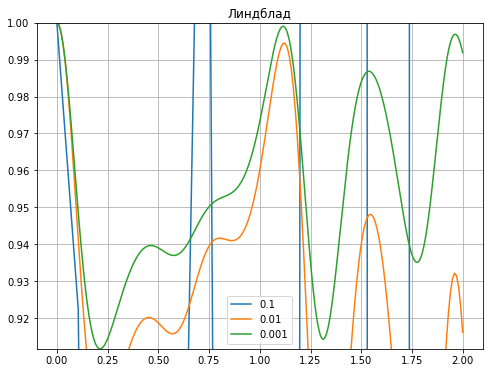

In [136]:
plt.figure(figsize=(8,6))

for i in range(len(dt_arr)):
    plt.plot(t_arr[i], fid_arr[i], label=f'{dt_arr[i]}')

plt.ylim(np.min(fid_arr[i]), 1)
plt.title("Линдблад")
plt.legend()
plt.grid(True)

C:\Users\duhak\AppData\Local\Temp/ipykernel_13380/3932887495.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  F[i] = Fidelity(rho_0, rho_t[i])
C:\Users\duhak\AppData\Local\Temp/ipykernel_13380/3932887495.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  F[i] = Fidelity(rho_0, rho_t[i])
C:\Users\duhak\AppData\Local\Temp/ipykernel_13380/3932887495.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  F[i] = Fidelity(rho_0, rho_t[i])


Wall time: 1.27 s


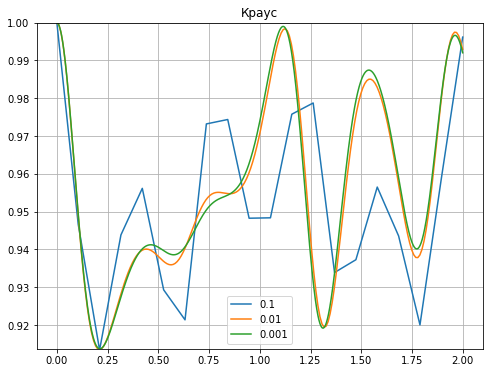

In [137]:
%%time
# Craus evolution
plt.figure(figsize=(8,6))

for dt in dt_arr:
    t = np.linspace(t_start, t_final, int((t_final-t_start)/dt))

    rho_t_craus = Heizenberg_evolution(t, H, mixed_rho, T2)
    
    fidelity_craus = Fidelity_evol(mixed_rho, rho_t_craus, t)
    
    plt.plot(t, fidelity_craus, label=dt)
    
plt.ylim(np.min(fidelity_craus), 1)
plt.title("Краус")
plt.legend()
plt.grid(True)

### Задание №2. Генерация случайных чисел

$$|\alpha\rangle = e^{\frac{-|\alpha|^2}{2}}\sum_{n=0}^{\infty} \frac{\alpha^n}{\sqrt{n!}} |n\rangle$$

Зададим точность, с которой будем моделировать состояние: acc = 1e-5
Далее найдём $N_{max}$ так, чтобы 
$$1-\sum^{N_{max}}_{n=0} |c_n|^2 \sim acc,$$
где $c_n = e^{\frac{-|\alpha|^2}{2}}\frac{\alpha^n}{\sqrt{n!}}$

In [215]:
from math import factorial as fact
from math import sqrt
from scipy import special
from tqdm import tqdm
from scipy.stats import norm

In [239]:
acc = 1e-5
alpha = 1.5 + 0*1j

def standard_basis(k, N):
    res = np.zeros(N+1)
    res[k] = 1
    return res

def coh_state(alpha, N_max=1):
    alpha_state = np.zeros(N_max+1, dtype=np.complex128)
    for n in range(N_max+1):
        alpha_state += alpha**n/sqrt(fact(n)) * standard_basis(n, N_max)
    return alpha_state * np.exp(-np.abs(alpha)**2/2)

In [240]:
# ищем N_max
delta = 1
c_n_sum = np.exp(-np.abs(alpha)**2)
N_max = 1
while delta > acc:
    c_n_sum += np.abs(alpha**N_max/sqrt(fact(N_max)))**2 * np.exp(-np.abs(alpha)**2)
    delta = 1 - c_n_sum
    N_max += 1

print('Максимальная рамерность фоковского пространства:', N_max)

Максимальная рамерность фоковского пространства: 12


In [291]:
cat_state = coh_state(alpha, N_max) + coh_state(-alpha, N_max)
C_alpha = np.linalg.norm(cat_state)
cat_state /= C_alpha

Принцип работы гомодинирования 
$$
    \hat{Q} = \frac{\hat{a} + \hat{a}^{\dagger}}{2}
$$
$$
    \hat{P} = \frac{\hat{a} - \hat{a}^{\dagger}}{2i}
$$
$$
\hat{Q_{\theta}} = \hat{Q}\cos\theta + \hat{P}\sin\theta = \left ( \frac{1}{2}\cos\theta -  \frac{i}{2}\sin\theta\right)\hat{a} + \left ( \frac{1}{2}\cos\theta + \frac{i}{2}\sin\theta\right)\hat{a}^{\dagger}
$$
$$
\hat{a}|n\rangle = \sqrt{n}|n - 1\rangle
$$
$$
\hat{a}^{\dagger}|n\rangle = \sqrt{n+1}|n + 1\rangle
$$

Для когерентых состояний с $\alpha = Q_0 + i P_0$ волновая функция в координатном и импульсном представлениях имеет вид:
$$
\psi_{\alpha}(Q) = (\frac{2}{\pi})^{1/4} e^{2i P_0 Q} e^{-(Q-Q_0)^2}\\ 
\psi_{\alpha}(P) = (\frac{2}{\pi})^{1/4} e^{-2i Q_0 P} e^{-(P-P_0)^2}
$$
В нашем случае:
$$
\psi_{cat}(Q) \sim (\frac{2}{\pi})^{1/4} e^{-(Q-1.5)^2} + (\frac{2}{\pi})^{1/4} e^{-(Q+1.5)^2}\\
\psi_{cat}(P) \sim (\frac{2}{\pi})^{1/4} e^{-2i 1.5 P} e^{-P^2} + (\frac{2}{\pi})^{1/4} e^{2i 1.5 P} e^{-P^2}
$$

In [297]:
def creation_m(N_max):
    a = np.zeros((N_max, N_max), dtype=np.float64)
    for i in range(1, N_max):
        a[i-1, i] = sqrt(i)
    return a

def annihilation_m(N_max):
    a = np.zeros((N_max, N_max), dtype=np.float64)
    for i in range(1, N_max):
        a[i, i-1] = sqrt(i)
    return a

def homodine(theta, vec, N_max):
    a = 0.5 * cos(theta) - 0.5j * sin(theta)
    b = 0.5 * cos(theta) + 0.5j * sin(theta)
    return a * annihilation(N_max) @ vec + b * creation(N_max) @ vec 

C_alpha = 1/np.sqrt(2*(1+np.exp(-2*np.abs(alpha)**2)))

def psi_Q(Q):
    C = C_alpha*(2/np.pi)**(1/4)
    return C*(np.exp(-(Q-alpha.real)**2) + np.exp(-(Q+alpha.real)**2))

def psi_P(P):
    C = C_alpha*(2/np.pi)**(1/4)
    return C*np.exp(-P**2)*(np.exp(-1j*2*alpha.real*P) + np.exp(1j*2*alpha.real*P))

def psi(x, theta):
    return cos(theta)**2 * np.abs(psi_Q(x))**2 + sin(theta)**2 * np.abs(psi_P(x))**2

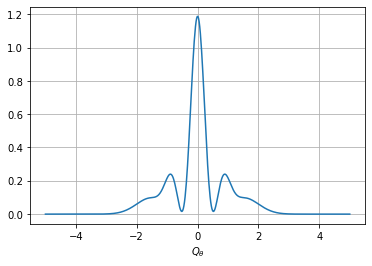

In [468]:
x = np.linspace(-5,5, 500)

theta = np.pi/3

plt.plot(x, psi(x,theta))
plt.xlabel(r"$Q_{\theta}$")
plt.grid(True)

#### метод метрополиса

In [299]:
def metropolis_alg(x_prev):
    #
    x_star = norm.rvs(loc = x_prev)
    a = psi(x_star, theta) / psi(x_prev, theta)
    rand = np.random.rand()
    if a > 1:
        return x_star
    elif a > rand:
        return x_star
    else:
        return x_prev

In [300]:
N = 100000
samples = np.zeros(N+1, dtype=np.float64)
samples[0] = 0.1
for i in tqdm(range(N)):
    samples[i+1] = metropolis_alg(samples[i])

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:11<00:00, 9052.92it/s]


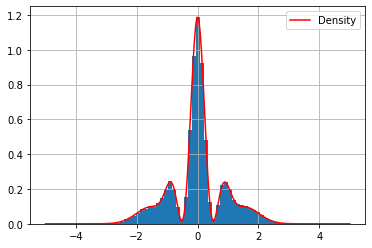

In [301]:
plt.hist(samples, bins=50, density=True)
plt.plot(x, psi(x,theta), color="red", label="Density")
plt.legend()
plt.grid(True)

#### метод обратной функции

In [383]:
import scipy.integrate as integrate
from scipy.optimize import minimize, minimize_scalar

In [465]:
%%time
def F(q):
    return integrate.quad(lambda x: psi(x, theta), -100, q)[0]

def F_fast(q):
    '''fast integration'''
    x = np.linspace(-100, q, 10000)
    y = psi(x, theta)
    return integrate.cumulative_trapezoid(y, x)[-1]

# plt.scatter(x, [F_fast(x[i]) for i in range(x.shape[0])])

Wall time: 0 ns


In [482]:
%%time
# обратная функция ищется по принципу нахождения минимальной точки в массиве np.abs(F_arr-y[i])
# F_arr просто расчитывается для каждой точки массива x
N = 10000
samples2 = np.zeros(N, dtype=np.float64)
x = np.linspace(-5,5, 500)
y = np.random.rand(N)
F_arr = [F(x[j]) for j in range(x.shape[0])] 

for i in tqdm(range(N)):
    a = np.abs(F_arr-y[i])
    samples2[i] = x[np.argmin(a)]

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 27618.14it/s]

Wall time: 2.22 s


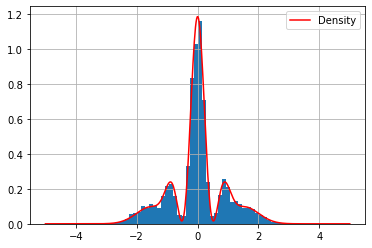

In [483]:
plt.hist(samples2, bins=50, density=True)
plt.plot(x, psi(x,theta), color="red", label="Density")
plt.legend()
plt.grid(True)

Видно, что алгоритм Метрополиса работает лучше, но медленнее метода обратной функции (хотя и несущественно). 

In [466]:
# слишком медленно!!!
# обратная функция вычисляется путём минимизации уравнения F(x)-y=0
%%time
samples2 = np.zeros(N, dtype=np.float64)
N = 10000
y = np.random.rand(N)

for i in tqdm(range(N)):
    # samples2[i] = minimize(lambda x: np.abs(F(x)-y[i]), x0=0, method='BFGS').x
    samples2[i] = minimize_scalar(lambda x: np.abs(F_fast(x)-y[i]), 
                                  method='brent', 
                                  #bracket=bracket
                                 ).x     

 14%|██████████▋                                                                  | 1385/10000 [01:45<10:58, 13.09it/s]


KeyboardInterrupt: 

No handles with labels found to put in legend.


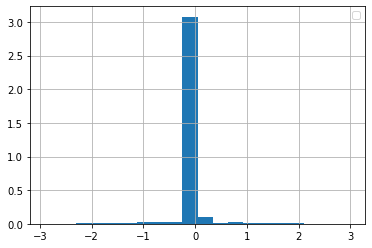

In [467]:
plt.hist(samples2, bins=20, density=True)
# plt.plot(x, psi(x,theta), color="red", label="Density")
plt.legend()
plt.grid(True)